In [3]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')

# 대략적인 구조 - 시계열

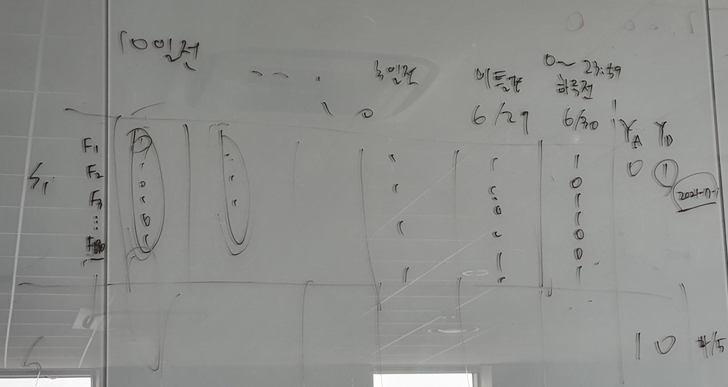

# 데이터 로드

In [4]:
환자 = pd.read_csv('/project/data/폐렴환자.csv', )
환자 = 환자[['SUBJECT_ID', 'EXPIRE_FLAG']]
환자

,SUBJECT_ID,EXPIRE_FLAG
0,252,0
1,253,0
2,268,1
3,269,0
4,665,1
...,...,...
7802,43932,1
7803,43937,1
7804,43959,0
7805,43982,0


In [7]:
lab = pd.read_csv('/project/data/폐렴환자lab.csv')
lab

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,FLAG
0,5144,9,150750.0,50819,2149-11-14 06:07:00,NaN
1,5145,9,150750.0,50820,2149-11-14 06:07:00,NaN
2,5146,9,150750.0,50821,2149-11-14 06:07:00,abnormal
3,5147,9,150750.0,50826,2149-11-14 06:07:00,NaN
4,5148,9,150750.0,50827,2149-11-14 06:07:00,NaN
...,...,...,...,...,...,...
9356344,27427231,96442,120151.0,51248,2115-06-29 04:45:00,NaN
9356345,27427232,96442,120151.0,51249,2115-06-29 04:45:00,NaN
9356346,27427233,96442,120151.0,51250,2115-06-29 04:45:00,NaN
9356347,27427234,96442,120151.0,51254,2115-06-29 04:45:00,abnormal


# 중복 제거

In [8]:
lab = lab.drop(['ROW_ID','HADM_ID'],axis=1)
lab[lab.duplicated()]

,SUBJECT_ID,ITEMID,CHARTTIME,FLAG
5560,68,51476,2173-08-10 01:17:00,NaN
5566,68,51491,2173-08-10 01:17:00,NaN
5568,68,51492,2173-08-10 01:17:00,NaN
5571,68,51498,2173-08-10 01:17:00,NaN
5574,68,51508,2173-08-10 01:17:00,NaN
...,...,...,...,...
9110916,92644,51362,2114-04-27 12:04:00,abnormal
9110918,92644,51363,2114-04-27 12:04:00,NaN
9243999,98358,51266,2177-04-17 02:43:00,NaN
9276864,98358,51266,2177-03-31 04:10:00,NaN


In [9]:
print("제거할 데이터 개수:", lab.duplicated().sum())
print("중복 제거 전 shape:", lab.shape)

lab.drop_duplicates(inplace=True)
print("모두 중복되는 샘플 제거 후 shape:", lab.shape)

제거할 데이터 개수: 6322
중복 제거 전 shape: (9356349, 4)
모두 중복되는 샘플 제거 후 shape: (9350027, 4)


# 생존여부와 JOIN

In [10]:
data = pd.merge(left = 환자 , right = lab, how = "inner", on = "SUBJECT_ID")
data = data[['SUBJECT_ID','ITEMID','CHARTTIME','FLAG','EXPIRE_FLAG']]
data['FLAG'] = data['FLAG'].str.replace('delta', 'nan')

In [11]:
data.shape

(9350027, 5)

In [12]:
data.head()

,SUBJECT_ID,ITEMID,CHARTTIME,FLAG,EXPIRE_FLAG
0,252,51237,2133-04-07 04:14:00,NaN,0
1,252,51248,2133-04-07 04:14:00,NaN,0
2,252,51249,2133-04-07 04:14:00,NaN,0
3,252,51250,2133-04-07 04:14:00,NaN,0
4,252,51265,2133-04-07 04:14:00,abnormal,0


# 전처리 - time

In [9]:
#시간 부분 제거, date 부분만 남김
import datetime as dt
data['CHARTTIME'] = pd.to_datetime(data['CHARTTIME'])
data['CHARTTIME'] = data['CHARTTIME'].dt.date

In [10]:
data = data.sort_values(['SUBJECT_ID','CHARTTIME']).reset_index(drop=True)
data

,SUBJECT_ID,ITEMID,CHARTTIME,FLAG,EXPIRE_FLAG
0,9,50856,2149-11-09,NaN,1
1,9,50868,2149-11-09,NaN,1
2,9,50879,2149-11-09,NaN,1
3,9,50880,2149-11-09,NaN,1
4,9,50882,2149-11-09,abnormal,1
...,...,...,...,...,...
9350022,99985,51006,2182-03-14,abnormal,0
9350023,99985,51146,2182-03-14,NaN,0
9350024,99985,51200,2182-03-14,NaN,0
9350025,99985,51221,2182-03-14,abnormal,0


# 캘린더 만들기(기록된 날짜 마지막 10개)

In [11]:
data[data['SUBJECT_ID']==252]['CHARTTIME'].unique()[-10:]

array([datetime.date(2133, 4, 23), datetime.date(2133, 8, 12),
       datetime.date(2133, 8, 15), datetime.date(2133, 8, 16),
       datetime.date(2133, 8, 17), datetime.date(2133, 8, 18),
       datetime.date(2133, 8, 19), datetime.date(2133, 10, 28),
       datetime.date(2133, 12, 25), datetime.date(2134, 2, 26)],
      dtype=object)

In [12]:
l1=[]
for i in data['SUBJECT_ID'].unique():
#     for j in days['SUBJECT_ID']:
#         if i == j:
    l1.append(data[data['SUBJECT_ID']==i]['CHARTTIME'].unique()[-10:])


In [13]:
days = pd.DataFrame(l1)
days['환자'] = data['SUBJECT_ID'].unique()
days = days.set_index('환자')

In [14]:
days

,0,1,2,3,4,5,6,7,8,9
환자,,,,,,,,,,
9,2149-11-09,2149-11-10,2149-11-11,2149-11-12,2149-11-13,2149-11-14,None,None,None,None
21,2135-01-10,2135-01-11,2135-01-30,2135-01-31,2135-02-01,2135-02-02,2135-02-03,2135-02-04,2135-02-05,2135-02-06
31,2108-08-22,2108-08-23,2108-08-24,2108-08-25,2108-08-26,2108-08-27,2108-08-28,2108-08-29,2108-08-30,None
36,2134-05-11,2134-05-12,2134-05-13,2134-05-14,2134-05-15,2134-05-16,2134-05-17,2134-05-18,2134-05-19,2134-05-20
37,2183-08-21,2183-08-22,2183-08-23,2183-08-24,2183-08-25,2183-08-26,2183-10-07,2184-04-27,None,None
...,...,...,...,...,...,...,...,...,...,...
99863,2142-04-28,2142-04-30,2142-05-01,2142-05-02,2142-05-03,2142-05-04,2142-05-05,2142-05-06,2142-05-07,2142-05-08
99934,2110-02-28,2110-03-01,2110-03-02,2110-03-03,2110-03-04,None,None,None,None,None
99937,2128-05-11,2128-05-12,2128-05-13,2128-05-14,2128-05-15,2128-05-16,2128-05-17,2128-05-18,2128-05-19,2128-05-20


# 최종 - 시간 제일 적게 걸리는 function 

In [18]:
ab_data = data[data['FLAG']=='abnormal']

In [19]:
from sklearn.preprocessing import LabelEncoder
zero_matrix = np.zeros((data['ITEMID'].nunique(), 10))
le = LabelEncoder()
df = pd.DataFrame(zero_matrix)
df.index = data['ITEMID'].sort_values().unique()


def fun4(subject_id):
    df1 = df.copy()
    ab2 = ab_data[(ab_data['SUBJECT_ID']==subject_id)&(ab_data['CHARTTIME'].isin(days.loc[subject_id].values))]
    
    ab2['CHARTTIME'] = le.fit_transform(ab2['CHARTTIME'])

    for item, day in zip(ab2['ITEMID'], ab2['CHARTTIME']):
        df1.loc[item, day] = 1
        
    return np.array(df1.values.reshape(1,690,10))

In [20]:
import time
start = time.time()  # 시작 시간 저장

arr = fun4(9)
for i in data['SUBJECT_ID'].unique()[1:50]:
#     print(test(i).shape)
    arr = np.append(arr, fun4(i), axis=0)
    
print("time :", time.time() - start) 
arr.shape

time : 4.3988282680511475


(50, 690, 10)

## sum으로 값 정확도 확인

In [27]:
for i in ab_data['SUBJECT_ID'].unique()[0:5]:
    print(fun4(i).sum())

77.0
160.0
122.0
104.0
78.0


In [23]:
for i in range(5):
    print(arr[i,:,:].sum())

77.0
160.0
122.0
104.0
78.0


## 최종 arr 생성 - 그래도 시간 좀 걸림

In [30]:
import time
start = time.time()  # 시작 시간 저장

arr = fun4(9)
for i in ab_data['SUBJECT_ID'].unique()[1:]:
#     print(test(i).shape)
    arr = np.append(arr, fun4(i), axis=0)
    
print("time :", time.time() - start) 
arr.shape

time : 862.5342147350311


(7799, 690, 10)

## 3dim array 파일로 저장

In [31]:
type(arr)

numpy.ndarray

### 방법 1 - np.save / np.load - 용량 큼 (약 420MB)

In [32]:
# save
np.save("3d_array.npy", arr)
# load
train = np.load("3d_array.npy")

In [34]:
train.shape

(7799, 690, 10)

### 방법 2 - pickle, gzip - 용량 작음 (약 1MB)

In [ ]:
import pickle
import gzip

# save and compress.
with gzip.open('3d_array.pickle', 'wb') as f:
    pickle.dump(arr, f)

In [43]:
# load and uncompress.
with gzip.open('3d_array.pickle','rb') as f:
    arr_data = pickle.load(f)

In [44]:
arr_data.shape

(7799, 690, 10)

# Label 생성

In [109]:
환자1 = 환자.sort_values(['SUBJECT_ID'])
환자1

,SUBJECT_ID,EXPIRE_FLAG
40,9,1
41,21,1
42,31,1
43,36,0
44,37,1
...,...,...
6748,99863,0
6749,99934,0
6750,99937,1
6878,99944,1


In [119]:
#외래환자(?) 제거 - 교집합 사용 (7807 -> 7799)
intersect_id = np.intersect1d(ab_data['SUBJECT_ID'].unique(), 환자1['SUBJECT_ID'].unique())
환자2 = 환자1[환자1['SUBJECT_ID'].isin(intersect_id)]

In [120]:
#index를 환자id로 설정 후, array로 변경
환자2 = 환자2.set_index('SUBJECT_ID')
label = np.array(환자2)

In [121]:
print(label.shape)
label

(7799, 1)


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [122]:
#이건 어차피 용량 작으므로 np.save/load 사용하여 저장
# save
np.save("3d_array_label.npy", label)
# load
yyy = np.load("3d_array_label.npy")

In [123]:
yyy

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

# shape 확인

In [125]:
arr.shape, label.shape

((7799, 690, 10), (7799, 1))

# label ver. 7799 x 2 

In [133]:
label

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [134]:
from sklearn import preprocessing

encoder = preprocessing.OneHotEncoder()

In [135]:
label_2d = encoder.fit_transform(label).toarray()

In [136]:
label_2d.shape

(7799, 2)

In [137]:
label_2d

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [143]:
#이건 어차피 용량 작으므로 np.save/load 사용하여 저장
# save
np.save("3d_array_label_2d.npy", label_2d)
# load
yyy2 = np.load("3d_array_label_2d.npy")

In [144]:
yyy2.shape

(7799, 2)